In [1]:
"""
Adapted from Track1/find.py
"""
import sys
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
try:
    IS_NOTEBOOK = True
    HERE = Path(__file__).resolve().parent
except NameError:
    IS_NOTEBOOK = False
    HERE = Path().resolve()

In [4]:
print(HERE)
sys.path.insert(0, str(Path(HERE, "..")))  # kinship root
sys.path.insert(0, str(Path(HERE, "..", "rfiw2021")))  # rfiw2021 dir

/warley/dev/research/kinship/notebooks


In [5]:
from dataset import FIWPair  # noqa: E402
from Track1.models import Net  # noqa: E402
from Track1.utils import set_seed  # noqa: E402

In [6]:
def extract_embeddings(val_loader, model):
    embeddings = []
    kin_relations = []
    face1_fids = []
    face2_fids = []

    for face1, face2, kin_relation, face1_fid, face2_fid in tqdm(val_loader):
        with torch.no_grad():
            embeddings1 = model.encoder(face1.cuda()).cpu().numpy()
            embeddings2 = model.encoder(face2.cuda()).cpu().numpy()
            embeddings.append(np.mean([embeddings1, embeddings2], axis=0))
            kin_relations.extend(kin_relation)
            face1_fids.extend(face1_fid.cpu().numpy())
            face2_fids.extend(face2_fid.cpu().numpy())

    # Now, embeddings contain all the embeddings
    embeddings = np.vstack(embeddings)
    kin_relations = np.vstack(kin_relations)
    face1_fids = np.vstack(face1_fids)
    face2_fids = np.vstack(face2_fids)

    return embeddings, (kin_relations, face1_fids, face2_fids)

In [122]:
def calculate_embeddings_2d(embeddings, perplexity):
    # This function will calculate the 2D embeddings given the original embeddings and a perplexity value.
    tsne = TSNE(n_components=2, perplexity=perplexity)
    return tsne.fit_transform(embeddings)


def get_indices(krs, f1fids, f2fids, label):
    # This function will get the indices for kin and non-kin relationships
    # given the `krs`, `f1fids`, and `f2fids` labels.
    idxs = [idx for idx, val in enumerate(krs) if val == label]
    kin_idxs = [idx for idx in idxs if f1fids[idx] == f2fids[idx]]
    nonkin_idxs = [idx for idx in idxs if f1fids[idx] != f2fids[idx]]
    return kin_idxs, nonkin_idxs


def plot_single_tsne(ax, embeddings_2d, kin_idxs, nonkin_idxs, f2fids, color, label):
    # This function will plot a single t-SNE plot given the 2D embeddings, indices, color, and label.
    if kin_idxs:
        ax.scatter(embeddings_2d[kin_idxs, 0], embeddings_2d[kin_idxs, 1], color=color, marker='.', label=f"{label} kin")
    if nonkin_idxs:
        ax.scatter(embeddings_2d[nonkin_idxs, 0], embeddings_2d[nonkin_idxs, 1], color=color, marker='x', label=f"{label} non-kin")
        for idx in nonkin_idxs:
            ax.text(embeddings_2d[idx, 0], embeddings_2d[idx, 1] - 1, f2fids[idx][0], fontsize=6)
    ax.legend()


def plot_embeddings(embeddings, labels, perplexities, plot_path: str = ""):
    # This is the main function that calls the other functions to generate and plot the t-SNE plots.

    krs, f1fids, f2fids = labels

    # Create a color map for kin relations: fs, gmgd, ms, gfgd, bb, md, fd, sibs, gmgs, gfgs, ss
    color_map = {
        "fs": "red",
        "gmgd": "orange",
        "ms": "darkred",
        "gfgd": "green",
        "bb": "blue",
        "md": "purple",
        "fd": "brown",
        "sibs": "pink",
        "gmgs": "gray",
        "gfgs": "olive",
        "ss": "cyan",
    }

    # Define n_subplots based on number of perplexity values
    n_subplots = len(perplexities)
    n_col = n_subplots // 2 if n_subplots > 1 else 1
    n_row = int(np.ceil(n_subplots / n_col))

    # Prepare a figure to hold the subplots
    fig, axes = plt.subplots(n_row, n_col, figsize=(10, 10 * n_row))
    if n_subplots > 1:
        axes = axes.flatten()  # Flatten the axes array to make it easier to work with
    else:
        axes = [axes]

    # Generate and plot t-SNE for different perplexity values
    for i, perplexity in enumerate(perplexities):
        print(f"Generating t-SNE with perplexity={perplexity}")
        embeddings_2d = calculate_embeddings_2d(embeddings, perplexity)

        ax = axes[i]  # Get the current subplot

        # Plot
        for label, color in color_map.items():
            kin_idxs, nonkin_idxs = get_indices(krs, f1fids, f2fids, label)
            plot_single_tsne(ax, embeddings_2d, kin_idxs, nonkin_idxs, f2fids, color, label)

        ax.set_title(f"Perplexity: {perplexity}")

    plt.tight_layout()
    if plot_path:
        plt.savefig(plot_path)
    plt.show()

In [44]:
def filter_embeddings(embeddings, labels, kin_relation: str = "", face1_fid: int = 0, face2_fid: int = 0):
    kin_relations, face1_fids, face2_fids = labels

    idxs_kr = np.arange(len(kin_relations)).reshape(-1, 1)
    idxs_f1 = np.arange(len(face1_fids)).reshape(-1, 1)
    idxs_f2 = np.arange(len(face2_fids)).reshape(-1, 1)

    if kin_relation:
        idxs_kr = idxs_kr[kin_relations == kin_relation]
    if face1_fid:
        idxs_f1 = idxs_f1[face1_fids == face1_fid]
    if face2_fid:
        idxs_f2 = idxs_f2[face2_fids == face2_fid]

    idxs = np.intersect1d(idxs_kr, idxs_f1)
    idxs = np.intersect1d(idxs, idxs_f2)
    labels = (kin_relations[idxs], face1_fids[idxs], face2_fids[idxs])

    return embeddings[idxs], labels

In [9]:
def setup_data(root_dir, csv_path, batch_size, samples_per_member: int = 1):
    # Loading and sampling the dataset
    val_dataset = FIWPair(
        root_dir=root_dir, csv_path=csv_path, families=[250, 283, 409, 735, 873], samples_per_member=samples_per_member
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False)
    return val_loader

In [10]:
def setup_model(model_path):
    # Loading model
    model = Net().cuda()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    set_seed(100)

    return model

In [11]:
root_dir = Path(HERE, "../rfiw2021/Track1/")
csv_path = Path(HERE, "../rfiw2021/Track1/sample0/val.txt")
batch_size = 40
model_path = Path(HERE, "../rfiw2021/Track1/model_track1.pth")
plot_path = ""

In [12]:
model = setup_model(model_path)

In [13]:
val_loader = setup_data(root_dir, csv_path, batch_size)

Total samples: 5846


In [14]:
# Extracting embeddings
embeddings, labels = extract_embeddings(val_loader, model)

  0%|                                                                                                      | 0/147 [00:00<?, ?it/s]/home/warley/.virtualenvs/rfiw2021/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:35<00:00,  4.15it/s]


In [95]:
# Filter embeddings
e, l = filter_embeddings(embeddings, labels, face1_fid=250, face2_fid=250)
e.shape

(113, 512)

Generating t-SNE with perplexity=10
Generating t-SNE with perplexity=40
Generating t-SNE with perplexity=70
Generating t-SNE with perplexity=100


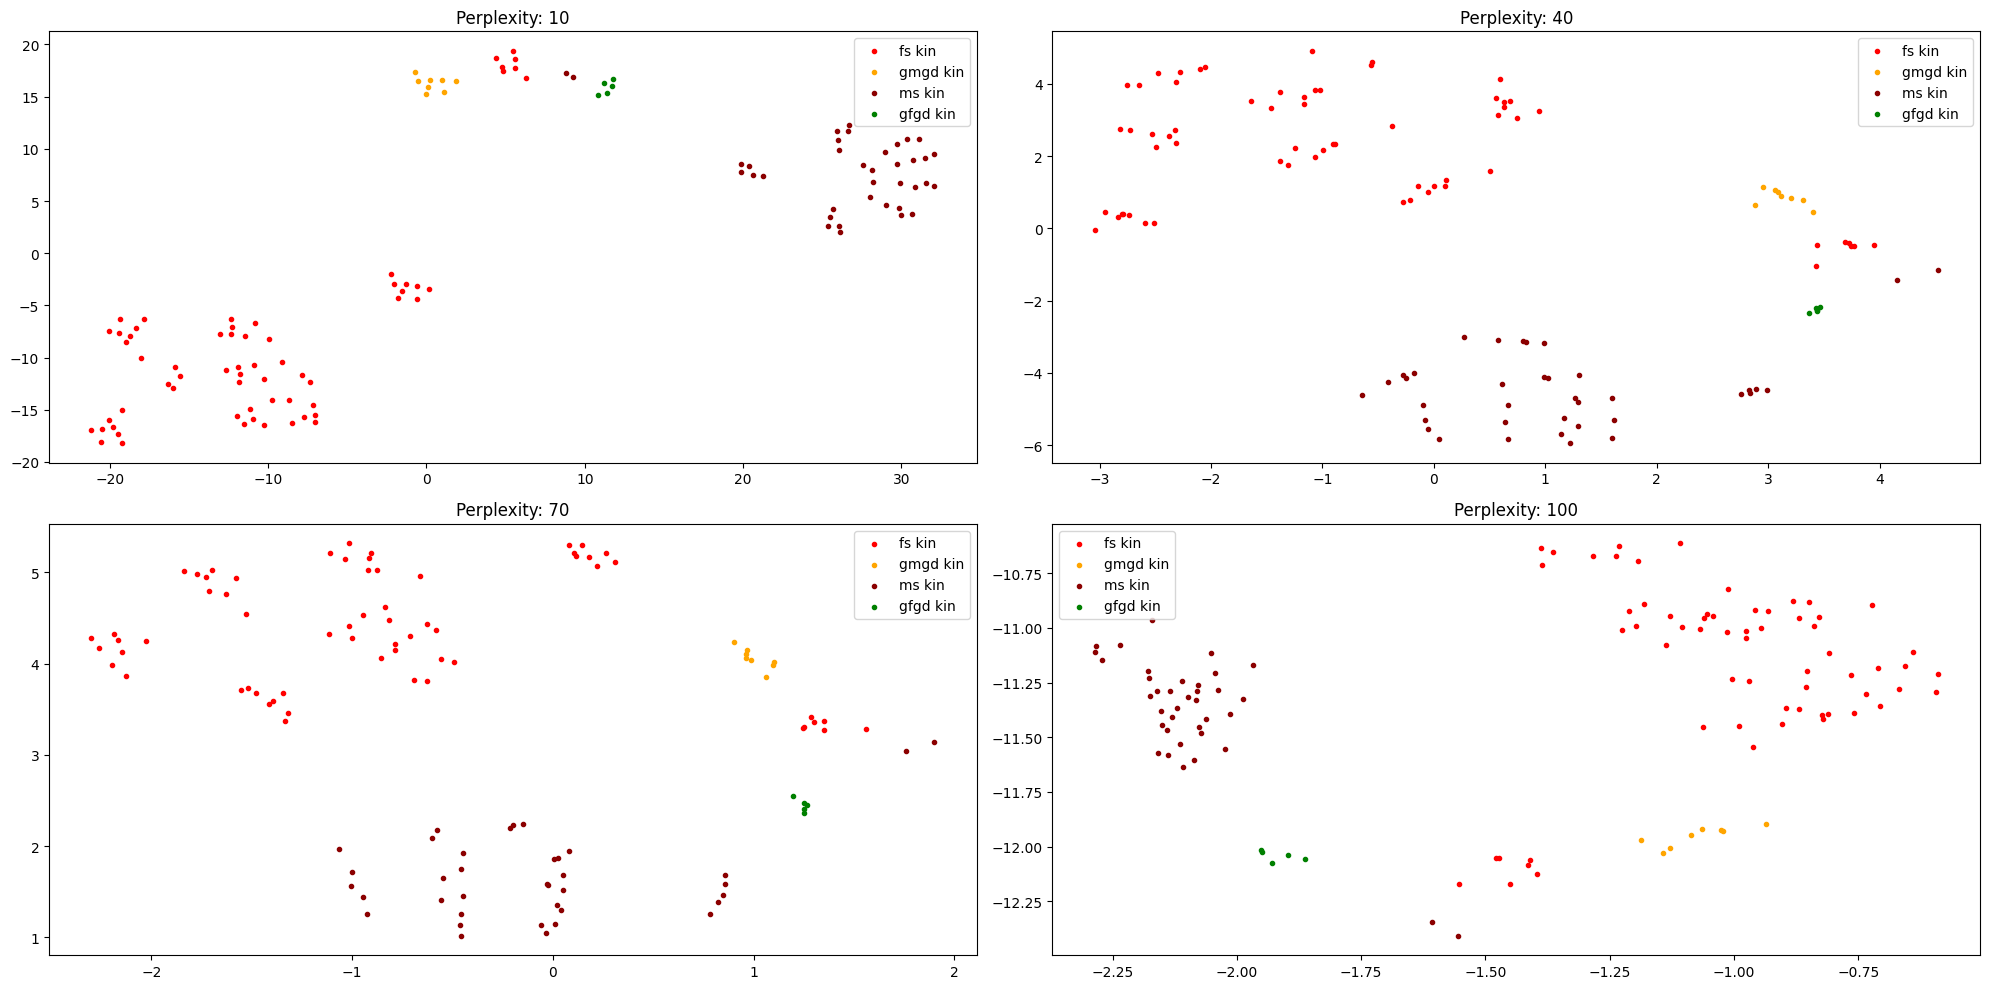

In [96]:
# Plotting
perplexities = range(10, 101, 30)
plot_embeddings(e, l, perplexities)

## Showing non kin pairs

In [97]:
# Filter embeddings
e, l = filter_embeddings(embeddings, labels, face1_fid=250)
e.shape

(264, 512)

Generating t-SNE with perplexity=10


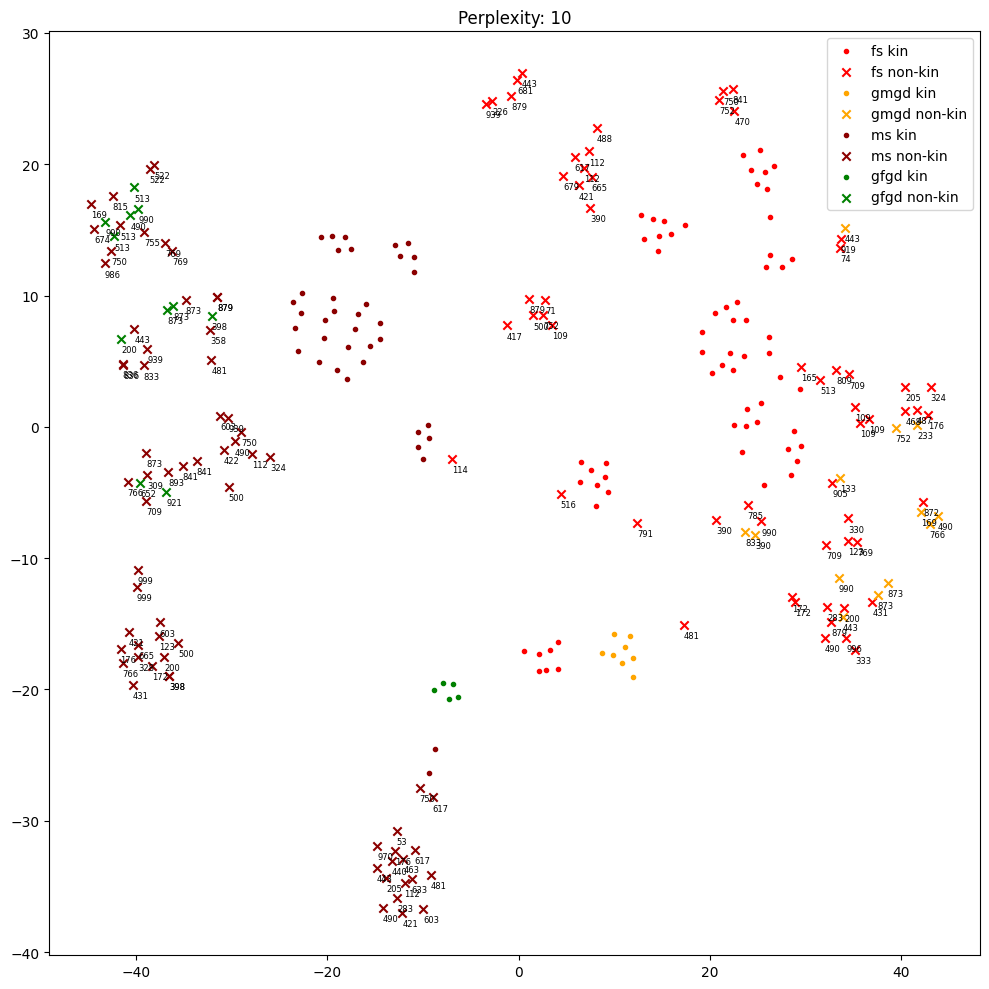

In [123]:
# Plotting
perplexities = [10]
plot_embeddings(e, l, perplexities)